In [1]:
import xarray as xr

from weather_class import WeatherData
from torch.utils.data import DataLoader

# base = xr.open_dataset('C:/Users/23603526/Documents/GitHub/WeatherForecasting/data/era5_training.nc')
base = xr.open_dataset('/teamspace/studios/this_studio/WeatherForecasting/data/era5_testing.nc')
base.load()

<xarray.Dataset> Size: 139MB
Dimensions:         (time: 1464, pressure_level: 1, latitude: 49, longitude: 69)
Coordinates:
  * time            (time) datetime64[ns] 12kB 2020-01-01 ... 2020-12-31T18:0...
  * pressure_level  (pressure_level) float64 8B 850.0
  * latitude        (latitude) float64 392B -35.0 -34.75 -34.5 ... -23.25 -23.0
  * longitude       (longitude) float64 552B 16.0 16.25 16.5 ... 32.5 32.75 33.0
Data variables:
    z               (time, pressure_level, latitude, longitude) float32 20MB ...
    r               (time, pressure_level, latitude, longitude) float32 20MB ...
    t               (time, pressure_level, latitude, longitude) float32 20MB ...
    u               (time, pressure_level, latitude, longitude) float32 20MB ...
    v               (time, pressure_level, latitude, longitude) float32 20MB ...
    w               (time, pressure_level, latitude, longitude) float32 20MB ...
    wind_speed      (time, pressure_level, latitude, longitude) float32 20MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-21T12:48 GRIB to CDM+CF via cfgrib-0.9.1...

In [37]:
window_size = 5
steps = 7
lightning = True
variable = 'wspd'
batch_size = 32
coarsen = 1


train_loader = DataLoader(WeatherData(base, window_size, steps, 'train', coarsen=coarsen, lightning=lightning, variable=variable), 
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(WeatherData(base, window_size, steps, 'val', coarsen=coarsen, lightning=lightning, variable=variable),
                        batch_size=batch_size, shuffle=False)

for i, data in enumerate(train_loader):
    x, F, M, y = data
    break

print('x shape:', x.shape)
print('F shape:', F.shape)
print('M shape:', M.shape)
print('y shape:', y.shape)

x shape: torch.Size([32, 5, 48, 64])
F shape: torch.Size([32, 2])
M shape: torch.Size([32, 48, 64])
y shape: torch.Size([32, 7, 48, 64])


In [22]:
import torch
import torch.nn as nn

class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x
    
class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x
 
class build_res_unet_time(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c, 64, kernel_size=3, padding=1)  # in_c + 2 to account for time inputs
        self.bn = nn.GroupNorm(64, 64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c, 64, kernel_size=1, padding=0)  # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(256, 512, stride=2)

        """ Decoder """
        self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, out_c, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()
        
        """ Time Embedding """
        self.time_mlp = nn.Sequential(
                    nn.Linear(2, 16),  # [hour, month] input size
                    nn.ReLU(),
                    nn.Linear(16,  24 * 32),
                    nn.ReLU(),
                )

    def step(self, x, F, M):

        batch_size, window_size, lat, lon = x.shape        

        # F[0] = F[0] / 24
        # F[1] = F[1] / 12

        # F = self.encode_time(F[:, 0], F[:, 1])
        # F = F.unsqueeze(-1).unsqueeze(-1)  
        # F = F.expand(-1, -1, lat, lon)  

        # time_indices = self.time_mlp(F).view(batch_size, 1, lat, lon)
        # print('time_indices shape:', time_indices.shape)
        # F_embedded = self.time_embedding(time_indices).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, lat, lon)

        # print('F_embedded shape:', F_embedded.shape)

        M = M.unsqueeze(1) / 2 

        combined_input = torch.cat([x, M], dim=1) #  F, , F_embedded , time_indices

        # print('combined_input shape:', combined_input.shape)

        """ Encoder 1 """
        out = self.c11(combined_input)
        out = self.bn(out)
        out = self.c12(out)
        s = self.c13(combined_input)
        skip1 = out + s
        # print('skip1 shape:', skip1.shape)

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        # print('skip2 shape:', skip2.shape)
        skip3 = self.r3(skip2)
        # print('skip3 shape:', skip3.shape)

        """ Bridge """
        b = self.r4(skip3)
        # print('b shape:', b.shape)

        """ Decoder """
        d1 = self.d1(b, skip3)
        # print('d1 shape:', d1.shape)
        d2 = self.d2(d1, skip2)
        # print('d2 shape:', d2.shape)
        d3 = self.d3(d2, skip1)
        # print('d3 shape:', d3.shape)

        """ Output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output

    def encode_time(self, hour, month):
        hour_sin = torch.sin(2 * torch.pi * hour / 24)
        hour_cos = torch.cos(2 * torch.pi * hour / 24)
        month_sin = torch.sin(2 * torch.pi * month / 12)
        month_cos = torch.cos(2 * torch.pi * month / 12)
        return torch.stack([hour_sin, hour_cos, month_sin, month_cos], dim=1)

    def rollout(self, x, F, M, steps):

        y_hats = torch.empty(x.size(0), steps, x.size(2), x.size(3), device=x.device)

        current_X = x
        for i in range(steps):
            y_hat = self.step(current_X, F, M)
            y_hats[:, i] = y_hat.squeeze(1)
            current_X = torch.cat((current_X[:, 1:], y_hat), dim=1)
            
            F[:, 0] = (F[:, 0] + 1) % 24

        return y_hats

    def forward(self, x, F, M, steps):
        return self.rollout(x, F, M, steps)

input_size = 6
output_size = 1
    
model = build_res_unet_time(input_size,  output_size)
out = model(x, F, M, 1)
out.shape

torch.Size([32, 1, 48, 64])

In [39]:
import datetime
import torch.nn as nn

import numpy as np

def init_weights(m: nn.Module) -> None:

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  
        if m.bias is not None:
            nn.init.constant_(m.bias, 0) 

def train_multi(train_loader, val_loader, model, epochs: int = 10, save_path: str = None, patience: int = 5, lr_: float = 0.0001, 
                batch_size_: int = 128, train_steps: int = 3, load_weights: str = None) -> None:
    
    if save_path is None:
        save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(betas=(0.9, 0.95), lr=lr_, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f'Training on {device}')
    
    if load_weights is not None:
        model.load_state_dict(torch.load(load_weights))
    else:
        model.apply(init_weights)

    model.to(device)
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    counter = 0

    for epoch in range(epochs):

        model.train()

        epoch_loss = 0
        
        for X_batch, F_batch, M_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            F_batch = F_batch.to(device)
            M_batch = M_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()

            counter += 1

            current_input = X_batch.clone()  # Initialize predictions with the first input state
            current_F = F_batch.clone()
            current_M = M_batch.clone()

            outputs = model(current_input, current_F, current_M, train_steps)

            loss = criterion(outputs, y_batch[:, :train_steps])

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

    

        avg_loss = epoch_loss / counter

        scheduler.step(avg_loss)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Best Loss: {best_loss}, LR: {optimizer.param_groups[0]["lr"]}')

        model.eval()

        val_loss = 0

        with torch.no_grad():
            counter = 0
            for X_val, F_val, M_val, y_val in val_loader:
                X_val = X_val.to(device)
                F_val = F_val.to(device)
                M_val = M_val.to(device)
                y_val = y_val.to(device)

                counter += 1

                y_hat = model(X_val, F_val, M_val, train_steps)

                loss = criterion(y_hat, y_val[:, :train_steps])

                val_loss += loss.item() * X_val.size(0)
            
        avg_val_loss = val_loss / counter

        print(f'Validation Loss: {avg_val_loss}')

        # Checkpointing
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model to {save_path}')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

    return model


model = train_multi(train_loader, val_loader, model, epochs=200, 
                            save_path='unet.pth', patience=5, lr_=0.00001, 
                            batch_size_=32, train_steps=7, load_weights='unet.pth')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training on cuda


Epoch 1/200, Loss: 0.12384932798643906, Best Loss: inf, LR: 1e-05
Validation Loss: 0.08776959973726083
Saved best model to unet.pth
Epoch 2/200, Loss: 0.042810833074547576, Best Loss: 0.08776959973726083, LR: 1e-05
Validation Loss: 0.08279066633743544
Saved best model to unet.pth
Epoch 3/200, Loss: 0.04390874437663252, Best Loss: 0.08279066633743544, LR: 1e-05
Validation Loss: 0.08121167874020158
Saved best model to unet.pth
Epoch 4/200, Loss: 0.04538757394942822, Best Loss: 0.08121167874020158, LR: 1e-05
Validation Loss: 0.09660526543545227
Epoch 5/200, Loss: 0.042361191431568426, Best Loss: 0.08121167874020158, LR: 1e-05
Validation Loss: 0.07537734315194415
Saved best model to unet.pth
Epoch 6/200, Loss: 0.040881620070925266, Best Loss: 0.07537734315194415, LR: 1e-05
Validation Loss: 0.08735397261934298
Epoch 7/200, Loss: 0.0393753390808618, Best Loss: 0.07537734315194415, LR: 1e-05
Validation Loss: 0.1177262707232413
Epoch 8/200, Loss: 0.04050713131966239, Best Loss: 0.0753773431519

x shape: torch.Size([32, 5, 48, 64])
y shape: torch.Size([32, 7, 48, 64])


Output shape:  torch.Size([32, 7, 48, 64])


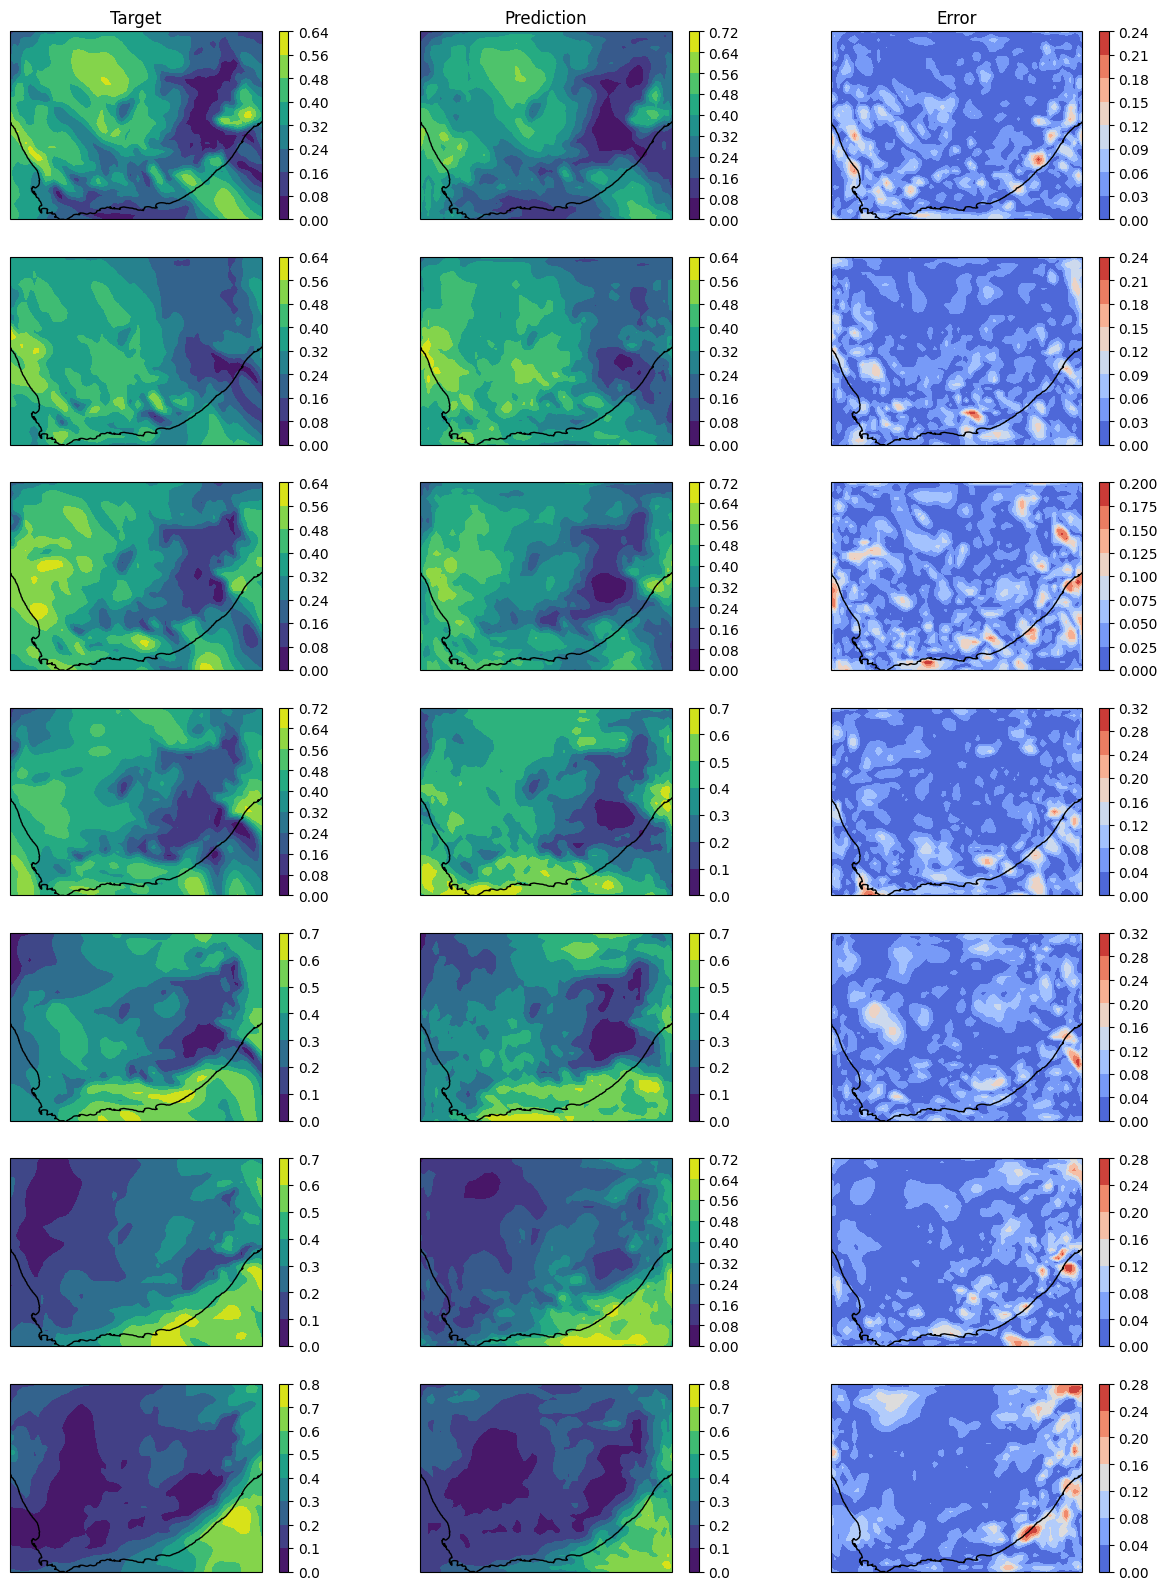

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

test_steps = 7

test_loader = DataLoader(WeatherData(base, window_size, test_steps, 'test', coarsen=coarsen, lightning=lightning, variable=variable),
                        batch_size=batch_size, shuffle=True)



for i, data in enumerate(test_loader):
    x, F, M, y = data
    break

print('x shape:', x.shape)
print('y shape:', y.shape)

model = build_res_unet_time(input_size,  output_size)
model.load_state_dict(torch.load('unet.pth'))
model.to('cpu')
model.eval()

# test_loss = 0

# criterion = nn.MSELoss()

# with torch.no_grad():
#     for X_test, F_test, M_test, y_test in test_loader:
#         y_hat = model(X_test, F_test, M_test, test_steps)
#         # print('y_hat shape:', y_hat.shape)
#         # print('y_test shape:', y_test.shape)
#         loss = criterion(y_hat, y_test[:, :test_steps])
#         test_loss += loss.item() * X_test.size(0)

# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss}')


y_hat = model(x, F, M, test_steps)
print('Output shape: ', y_hat.shape)

seed = 20

fig, axs = plt.subplots(test_steps, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    for a in ax:
        a.coastlines()

for i in range(test_steps):
    tar = axs[i, 0].contourf(base.isel(longitude=slice(2, 66, coarsen)).longitude, base.isel(latitude=slice(1, 49, coarsen)).latitude, y[seed, i].detach().numpy())
    plt.colorbar(tar, ax=axs[i, 0])
    pred = axs[i, 1].contourf(base.isel(longitude=slice(2, 66, coarsen)).longitude,  base.isel(latitude=slice(1, 49, coarsen)).latitude, y_hat[seed, i].detach().numpy())
    plt.colorbar(pred, ax=axs[i, 1])
    error = np.abs(y[seed, i].detach().numpy() - y_hat[seed, i].detach().numpy())
    err = axs[i, 2].contourf(base.isel(longitude=slice(2, 66, coarsen)).longitude,  base.isel(latitude=slice(1, 49, coarsen)).latitude, error, cmap='coolwarm')
    plt.colorbar(err, ax=axs[i, 2])

axs[0, 0].set_title('Target')
axs[0, 1].set_title('Prediction')
axs[0, 2].set_title('Error')


plt.show()

